# Phylogenetic Tree of HIV Sequences

**Authors:** [Tony Kabilan Okeke](mailto:tko35@drexel.edu), [Ifeanyi Osuchukwu](mailto:imo27@drexel.edu)  
**Date:** 03.10.2022

A collection of HIV tat sequences were obtained from [here](https://www.hiv.lanl.gov/content/sequence/NEWALIGN/align.html), using "Compendium" DNA sequences. You do not need to re-obtain those sequences. Use the fastafile as provided below:

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
# Imports
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import bmes
import re

from scipy.cluster import hierarchy
from scipy.spatial import distance
from Bio import SeqIO, pairwise2

In [3]:
# Definitions
def corrected_pdistance(a: str, b: str) -> float:
    """
    Compute the poisson corrected p-distance between two sequences.
    The p-distances are calculated based on the semiglobal (free end gaps)
    alignment of the sequences.
    """

    # Align sequences
    align = pairwise2.align.globalxx(a, b, penalize_end_gaps=False)[0]
    # Store aligned sequences
    a, b = align.seqA, align.seqB
    denom = align.end - align.start
    # Compute fraction of mismatches (p-distance)
    pdist = 0
    for i,j in zip(a,b):
        if i != j: pdist += 1
    pdist = pdist/denom

    # Return poisson corrected p-distance
    return -np.log(1 - pdist)

In [4]:
# Download fasta file
fastafile = bmes.downloadurl('http://sacan.biomed.drexel.edu/lib/exe/fetch.php?rev=&media=course:binf:phylo:hwphylo:HIV1_COM_2017_tat_DNA.fasta');

### Read the HIV tat Sequences and Extract the Subtype Names

HIV-1 viruses are categorized into strains A-K based on their genomic sequences. In this assignment, you will only analyze the virus strains A-K.

<img src="HIV-types-strains-v1.webp" width="400">     Figure from [here](https://www.avert.org/professionals/hiv-science/types-strainshttps://www.avert.org/professionals/hiv-science/types-strains)

The sequence names are composed of strain, country, year of isolation, plus additional identifiers, e.g., the sequence "F2.CM.11.DEURF11CM026.KU749422", has a strain name of "F2", country "CM" (Cameroon), and year "11".  

Read the fasta file. Filter sequences and only keep the strains A through K. Strain names may be followed by a number, e.g., the strain F2 is considered as strain F, and should be kept. You will only use strains A-K for the rest of the assignment.

In [5]:
# Parse reads
reads = list(SeqIO.parse(fastafile, 'fasta'))

# Filter out strains A through K
pattern = r"^([A-K]\d*)\.([^\.]+)\.([^\.]*).*"
reads = filter(lambda read: re.search(pattern, read.name) != None, reads)

# Clean up read names, and store data in a dataframe
reads = [{'name': re.sub(pattern, r"\1-\2-\3", read.name),
          'seq': str(read.seq)} for read in reads]
df = pd.DataFrame(reads)

df.head()

,name,seq
0,B-FR-83,ATGGAGCCAGTAGATCCTAGACTAGAGCCCTGGAAGCATCCAGGAA...
1,A1-CD-02,ATGGAGCTGGTAGACCCTAACCTAGATCCCTGGAATCATCCGGGAA...
2,A1-CM-08,ATGGATCCGGTAGATCCTAACCTAGAGCCCTGGAACCATCCAGGAA...
3,A1-ES-15,ATGGATCCGATAGATCCTAACCTAGAGCCCTGGAATCATCCAGGAA...
4,A1-KE-11,ATGGATCCAGTAGATCCTAACATAGAGCCCTGGAATCACCCGGGAA...


### Draw a Phylogenetic Tree of the HIV Sequences (Only Strains A-K)

Your phylogenetic tree should be based on the Poisson corrected p-distance. The phylogenetic tree time scale should reflect the Poisson corrected p-distance (not a percentage). The p-distance between the two sequences should be obtained using global alignment with free end gaps.

> *p-distance* is the fraction of nonidentical (mismatched) alignment positions.  
> *Poisson corrected p-distance* $=-\ln(1-p)$

In [6]:
# Number of sequences
N = df.shape[0]

# Initialize the distance matrix
dist = np.zeros((N,N))

# Populate matrix (upper triangular)
for i in range(N):
    for j in range(i+1, N):
        dist[i,j] = corrected_pdistance(*df.seq[[i,j]])

# Convert upper triangular matrix to symmetric matrix
dist = np.where(dist, dist, dist.T)

# Convert distance matrix to squareform
dist = distance.squareform(dist)

# Perform hierarchical clustering on data to generate phylogenetic tree
phy = hierarchy.linkage(dist, 'average')

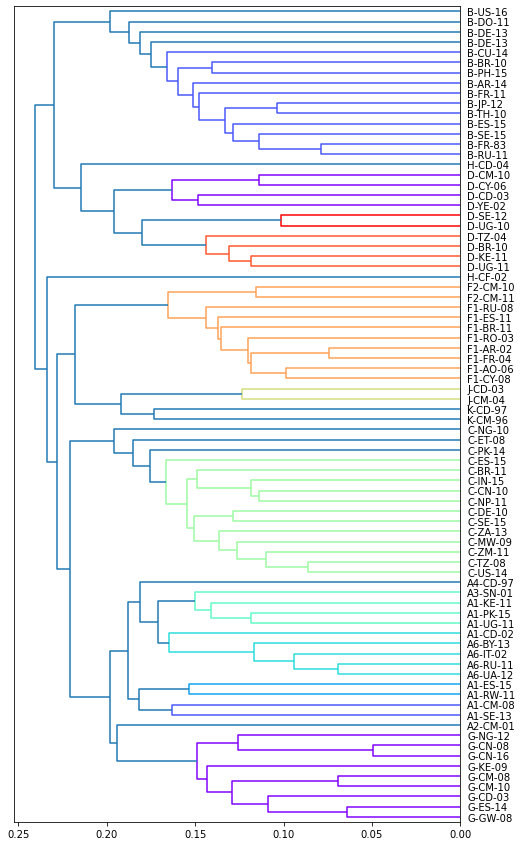

In [7]:
# Plot phylogenetic tree
plt.figure(figsize=(8,15))
cmap = plt.cm.rainbow(np.linspace(0, 1, 10))
hierarchy.set_link_color_palette([mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap])
hierarchy.dendrogram(phy, orientation='left', labels=df.name.to_list(),
                     distance_sort='descending', show_leaf_counts=True)
plt.yticks(fontsize=10)
plt.show()

### Interpret

Sequences from which HIV subtype(s) do not cluster well? (i.e., sequences from which subtype have diverged from the sequences of the same subtype). You do not need to write any code here. Your answer can be based on visual inspection of the tree you constructed above.

In [8]:
# It appears that subtypes H-CD-04 and H-CF-02 have diverged from 
# one anohter and cluster at a large euclidean distance.